In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import os

In [5]:
# Load our reports 
path = 'dataset-quarterback_scouting_reports'
filename = 'qb_draft_reports_topics.csv'

df = pd.read_csv(os.path.join(path, filename))
df.head(3)

,Player,Year,Race,School,Source,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Report
0,Zach Wilson,2021,White,BYU,NFL,0.381061,0.236944,0.135174,0.000736,0.246084,Wilson was the runner-up for Utah's Mr Footb...
1,Zach Wilson,2021,White,BYU,ESPN,0.048303,0.034207,0.003432,0.003457,0.910600,Wilson is a lean quarterback with good mobili...
2,Zach Wilson,2021,White,BYU,WalterFootball,0.040671,0.310405,0.030380,0.229075,0.389470,Powerful right arm Can make all the throws i...


In [6]:
df.insert(5, 'Dominant_Topic', '')
cols = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
tmp = df[cols]

for index, row in df.iterrows():
    df.at[index, 'Dominant_Topic'] = tmp.loc[index].idxmax()

df.head(3)

,Player,Year,Race,School,Source,Dominant_Topic,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Report
0,Zach Wilson,2021,White,BYU,NFL,Topic_1,0.381061,0.236944,0.135174,0.000736,0.246084,Wilson was the runner-up for Utah's Mr Footb...
1,Zach Wilson,2021,White,BYU,ESPN,Topic_5,0.048303,0.034207,0.003432,0.003457,0.910600,Wilson is a lean quarterback with good mobili...
2,Zach Wilson,2021,White,BYU,WalterFootball,Topic_5,0.040671,0.310405,0.030380,0.229075,0.389470,Powerful right arm Can make all the throws i...


In [7]:
df = df[['Player', 'Year', 'Race', 'Dominant_Topic', 'Report']]
df.head(5)

,Player,Year,Race,Dominant_Topic,Report
0,Zach Wilson,2021,White,Topic_1,Wilson was the runner-up for Utah's Mr Footb...
1,Zach Wilson,2021,White,Topic_5,Wilson is a lean quarterback with good mobili...
2,Zach Wilson,2021,White,Topic_5,Powerful right arm Can make all the throws i...
3,Zach Wilson,2021,White,Topic_2,Wilson rose up draft boards this season more ...
4,Trey Lance,2021,Non-White,Topic_1,As a redshirt freshman in 2019 Lance won the...


In [8]:
# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

def format_output(output_dict):
  
  polarity = "Neutral"

  if(output_dict['compound']>= 0.1):
    polarity = "Positive"

  elif(output_dict['compound']<= -0.1):
    polarity = "Negative"

  return polarity

def predict_sentiment(text):
  
  output_dict =  sent_analyzer.polarity_scores(text)
  return format_output(output_dict)

In [9]:
df['Sentiment'] = df['Report'].apply(predict_sentiment)
df.head(5)

,Player,Year,Race,Dominant_Topic,Report,Sentiment
0,Zach Wilson,2021,White,Topic_1,Wilson was the runner-up for Utah's Mr Footb...,Positive
1,Zach Wilson,2021,White,Topic_5,Wilson is a lean quarterback with good mobili...,Positive
2,Zach Wilson,2021,White,Topic_5,Powerful right arm Can make all the throws i...,Positive
3,Zach Wilson,2021,White,Topic_2,Wilson rose up draft boards this season more ...,Positive
4,Trey Lance,2021,Non-White,Topic_1,As a redshirt freshman in 2019 Lance won the...,Positive


In [10]:
df['Sentiment'].value_counts()

Positive    594
Negative     37
Neutral       5
Name: Sentiment, dtype: int64

In [11]:
df0 = pd.concat([df, pd.get_dummies(df['Sentiment'])], axis=1)[['Player', 'Year', 'Race', 'Dominant_Topic', 'Positive', 'Neutral', 'Negative']]
df1 = pd.DataFrame([[df['Sentiment'].value_counts()[i] for i in range(3)]], columns=['Positive', 'Negative', 'Neutral'])
df1 = df1[['Negative', 'Neutral', 'Positive']]
df1 = df1.div(df1.sum(axis=1), axis=0)
df1

,Negative,Neutral,Positive
0,0.058176,0.007862,0.933962


In [12]:
df2 = df0.groupby('Race').sum(numeric_only=True).reset_index().drop('Year', axis=1)
df2 = pd.concat([df2[['Race']], df2[['Negative', 'Neutral', 'Positive']].div(df2.sum(axis=1, numeric_only=True), axis=0)], axis=1)
df2

,Race,Negative,Neutral,Positive
0,Non-White,0.080645,0.005376,0.913978
1,White,0.048889,0.008889,0.942222


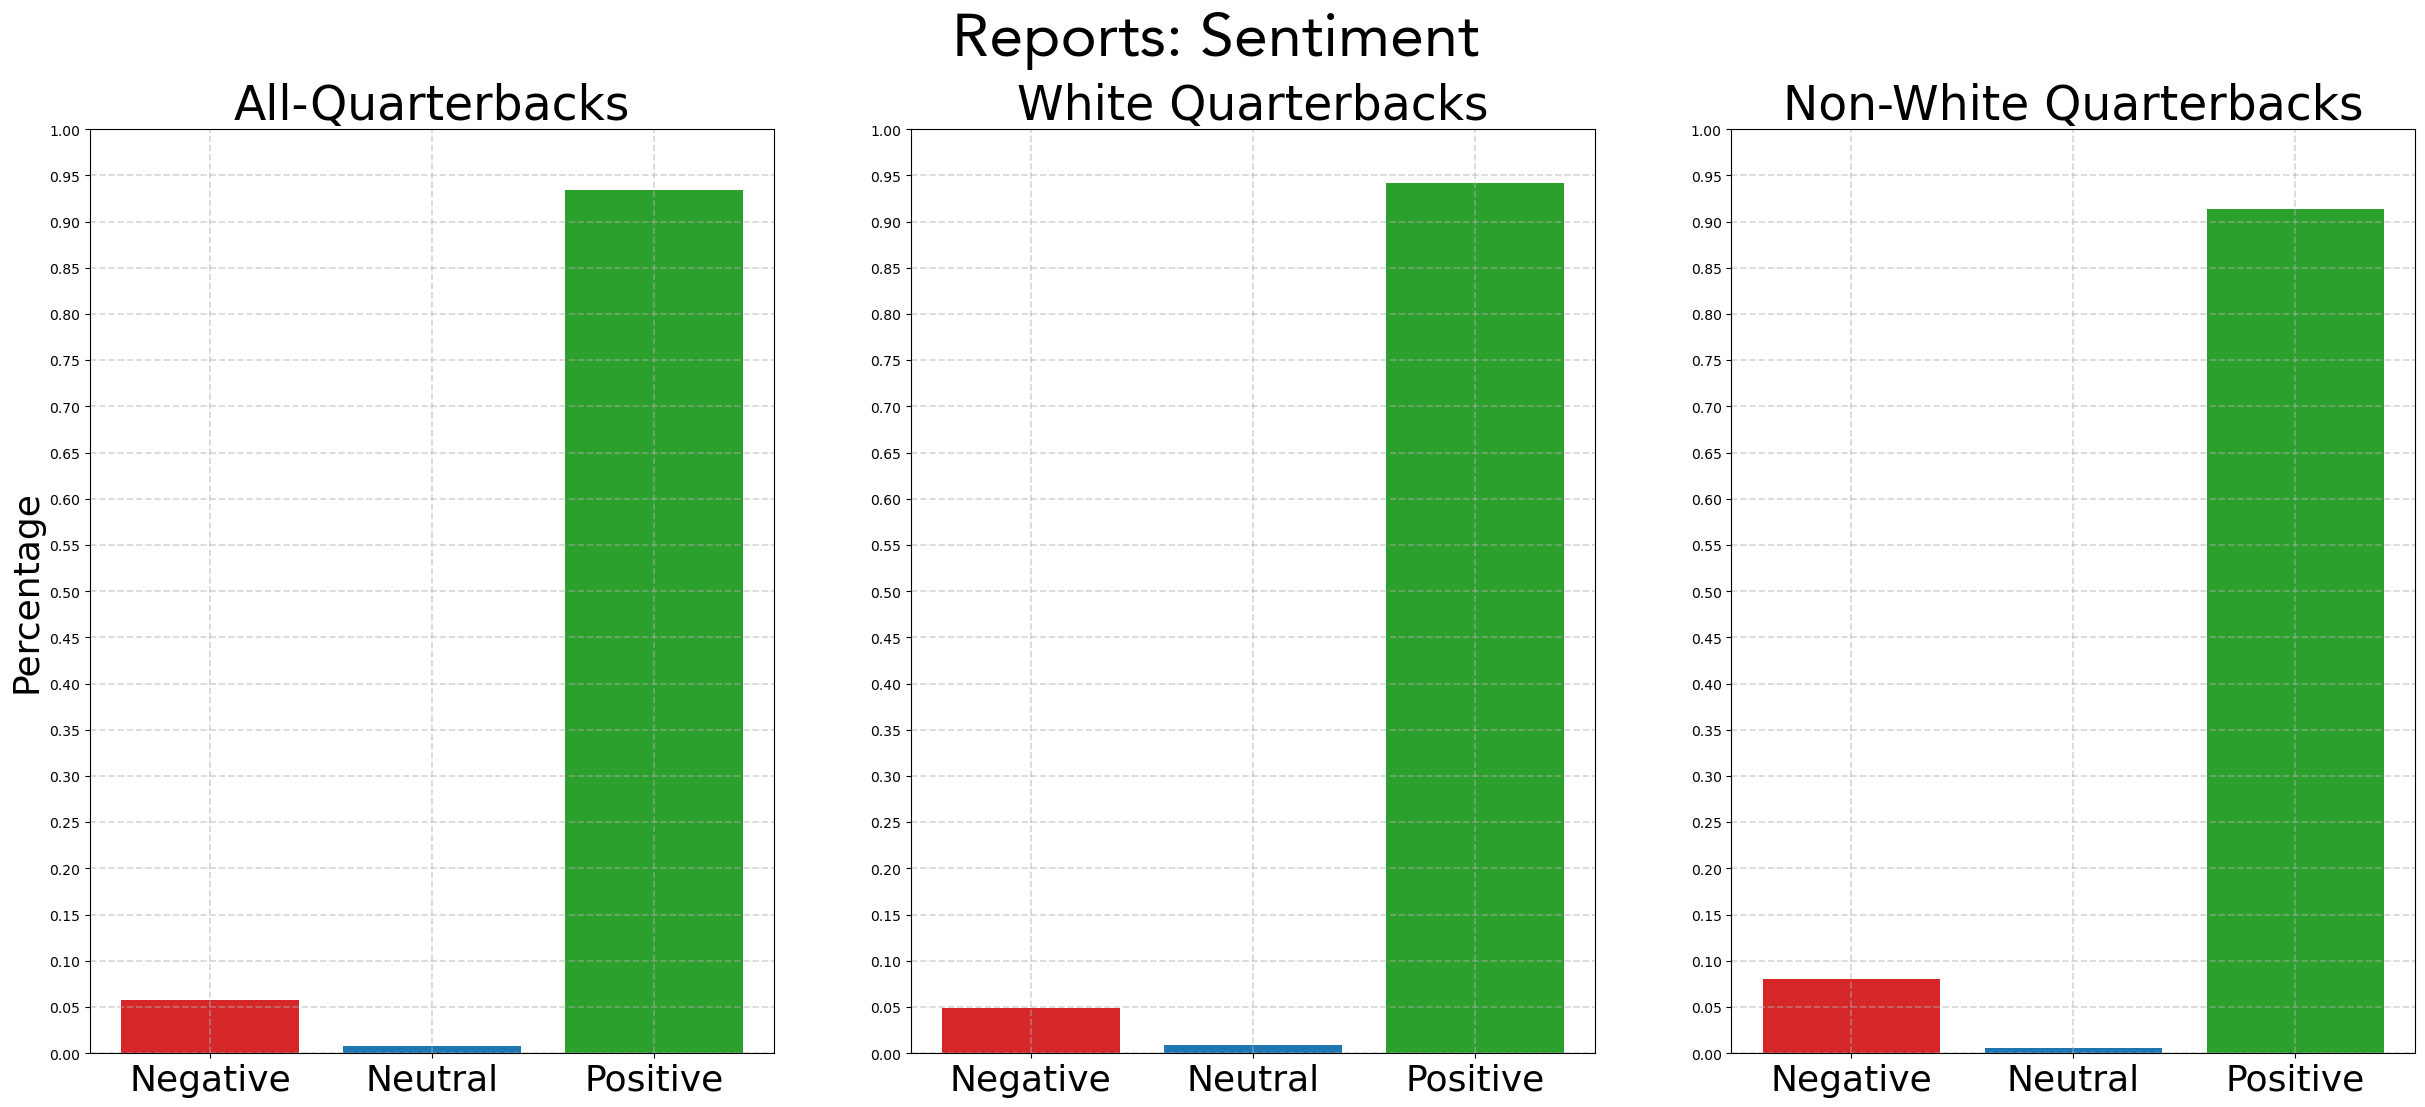

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams.update({'font.size': 20})

topics = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
topics_ticks = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']

sents = ['Negative', 'Neutral', 'Positive']

colors_5 = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
colors_3 = ['tab:red', 'tab:blue', 'tab:green']

yticks = np.arange(0, 1.01, 0.05)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df1.loc[0]
ax.bar(sents, y, color=colors_3)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('All-Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('Percentage', fontsize=26)

ax = axs[1]
y = df2[df2['Race'] == 'White'][sents].reset_index(drop=True).loc[0]
ax.bar(sents, y, color=colors_3)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('White Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('', fontsize=26)

ax = axs[2]
y = df2[df2['Race'] == 'Non-White'][sents].reset_index(drop=True).loc[0]
ax.bar(sents, y, color=colors_3)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('Non-White Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('', fontsize=26)

plt.suptitle('Reports: Sentiment', fontsize=44)
plt.show()

In [14]:
# Load topics
path = 'dataset-quarterback_scouting_reports'
filename = 'qb_draft_reports_topics.csv'

data = pd.read_csv(os.path.join(path, filename))

In [15]:
data0 = data[['Race', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']].mean(numeric_only=True)
data1 = pd.DataFrame([[data0[i] for i in range(5)]], columns=['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5'])
data1

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,0.147745,0.253529,0.147594,0.052781,0.398352


In [16]:
df3 = df0.groupby('Dominant_Topic').sum(numeric_only=True).reset_index().drop('Year', axis=1)
df3 = pd.concat([df3[['Dominant_Topic']], df3[['Negative', 'Neutral', 'Positive']].div(df3.sum(axis=1, numeric_only=True), axis=0)], axis=1)
df3

,Dominant_Topic,Negative,Neutral,Positive
0,Topic_1,0.053571,0.000000,0.946429
1,Topic_2,0.036585,0.012195,0.951220
2,Topic_3,0.087500,0.012500,0.900000
3,Topic_4,0.047619,0.000000,0.952381
4,Topic_5,0.063492,0.006349,0.930159


In [17]:
data2 = data[['Race', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']].groupby('Race').mean().reset_index()
data2

,Race,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,Non-White,0.146783,0.257125,0.144684,0.058034,0.393374
1,White,0.148142,0.252043,0.148796,0.050609,0.400409


In [18]:
df4 = df0.groupby(['Race', 'Dominant_Topic']).sum(numeric_only=True).reset_index().drop('Year', axis=1)
df4 = pd.concat([df4[['Race', 'Dominant_Topic']], df4[['Negative', 'Neutral', 'Positive']].div(df4.sum(axis=1, numeric_only=True), axis=0)], axis=1).sort_values('Dominant_Topic').reset_index(drop=True)
df4

,Race,Dominant_Topic,Negative,Neutral,Positive
0,Non-White,Topic_1,0.071429,0.000000,0.928571
1,White,Topic_1,0.047619,0.000000,0.952381
2,Non-White,Topic_2,0.057692,0.019231,0.923077
3,White,Topic_2,0.026786,0.008929,0.964286
4,Non-White,Topic_3,0.250000,0.000000,0.750000
5,White,Topic_3,0.033333,0.016667,0.950000
6,Non-White,Topic_4,0.000000,0.000000,1.000000
7,White,Topic_4,0.066667,0.000000,0.933333
8,Non-White,Topic_5,0.063830,0.000000,0.936170
9,White,Topic_5,0.063348,0.009050,0.927602


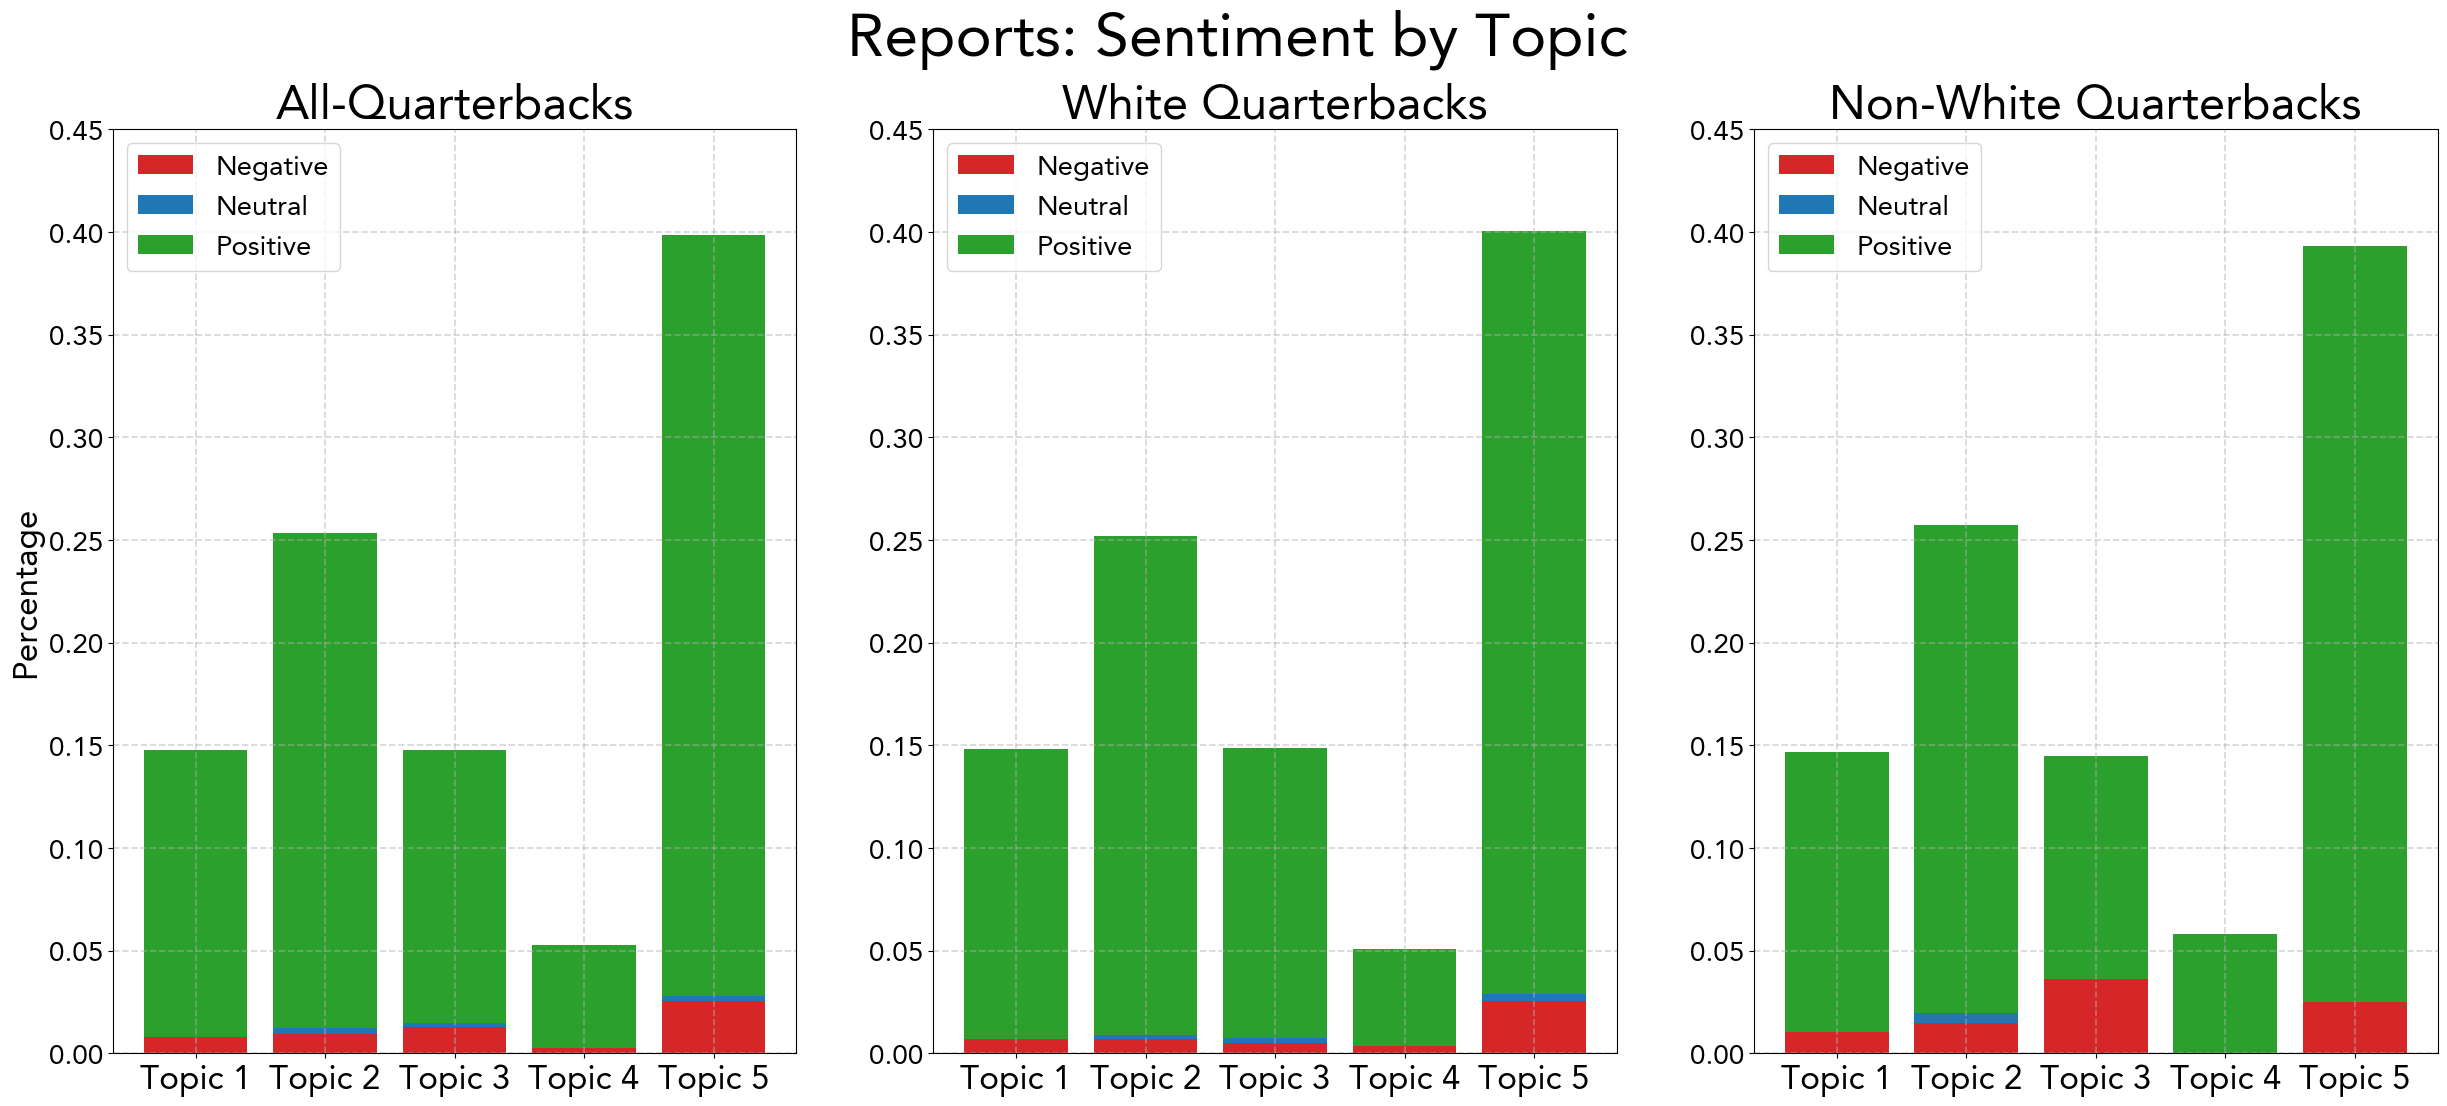

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams.update({'font.size': 20})

topics = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']

sents = ['Negative', 'Neutral', 'Positive']

colors_5 = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
colors_3 = ['tab:red', 'tab:blue', 'tab:green']

yticks = np.arange(0, 0.46, 0.05)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y1 = df3['Negative'] * np.array(data1.loc[0])
y2 = df3['Neutral'] * np.array(data1.loc[0])
y3 = df3['Positive'] * np.array(data1.loc[0])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('All-Quarterbacks', fontsize=34)
ax.legend()
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('Percentage', fontsize=24)

ax = axs[1]
y1 = df4[df4['Race'] == 'White']['Negative'] * np.array(data2[data2['Race'] == 'White'].reset_index(drop=True).loc[0][1:])
y2 = df4[df4['Race'] == 'White']['Neutral'] * np.array(data2[data2['Race'] == 'White'].reset_index(drop=True).loc[0][1:])
y3 = df4[df4['Race'] == 'White']['Positive'] * np.array(data2[data2['Race'] == 'White'].reset_index(drop=True).loc[0][1:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('White Quarterbacks', fontsize=34)
ax.legend()
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('', fontsize=24)

ax = axs[2]
y1 = df4[df4['Race'] == 'Non-White']['Negative'] * np.array(data2[data2['Race'] == 'Non-White'].reset_index(drop=True).loc[0][1:])
y2 = df4[df4['Race'] == 'Non-White']['Neutral'] * np.array(data2[data2['Race'] == 'Non-White'].reset_index(drop=True).loc[0][1:])
y3 = df4[df4['Race'] == 'Non-White']['Positive'] * np.array(data2[data2['Race'] == 'Non-White'].reset_index(drop=True).loc[0][1:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('Non-White Quarterbacks', fontsize=34)
ax.legend()
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('', fontsize=24)

plt.suptitle('Reports: Sentiment by Topic', fontsize=44)
plt.show()

In [17]:
df0.insert(2, 'Period', '')

for index, row in df0.iterrows():
    if row['Year'] <= 2011:
        df0.at[index, 'Period'] = '2007-2011'
    elif row['Year'] >= 2017:
        df0.at[index, 'Period'] = '2017-2021'
    else:
        df0.at[index, 'Period'] = '2012-2016'

df0.head(3)

,Player,Year,Period,Race,Dominant_Topic,Positive,Neutral,Negative
0,Zach Wilson,2021,2017-2021,White,Topic_1,1,0,0
1,Zach Wilson,2021,2017-2021,White,Topic_5,1,0,0
2,Zach Wilson,2021,2017-2021,White,Topic_5,1,0,0


In [18]:
df5 = df0.groupby('Period').sum(numeric_only=True).reset_index().drop('Year', axis=1)
df5 = pd.concat([df5[['Period']], df5[['Negative', 'Neutral', 'Positive']].div(df5.sum(axis=1, numeric_only=True), axis=0)], axis=1)
df5

,Period,Negative,Neutral,Positive
0,2007-2011,0.050209,0.008368,0.941423
1,2012-2016,0.062147,0.005650,0.932203
2,2017-2021,0.063636,0.009091,0.927273


In [19]:
df6 = df0.groupby(['Race', 'Period']).sum(numeric_only=True).reset_index().drop('Year', axis=1).sort_values('Period').reset_index(drop=True)
df6 = pd.concat([df6[['Race', 'Period']], df6[['Negative', 'Neutral', 'Positive']].div(df6.sum(axis=1, numeric_only=True), axis=0)], axis=1)
df6

,Race,Period,Negative,Neutral,Positive
0,Non-White,2007-2011,0.080645,0.016129,0.903226
1,White,2007-2011,0.039548,0.005650,0.954802
2,Non-White,2012-2016,0.094340,0.000000,0.905660
3,White,2012-2016,0.048387,0.008065,0.943548
4,Non-White,2017-2021,0.070423,0.000000,0.929577
5,White,2017-2021,0.060403,0.013423,0.926174


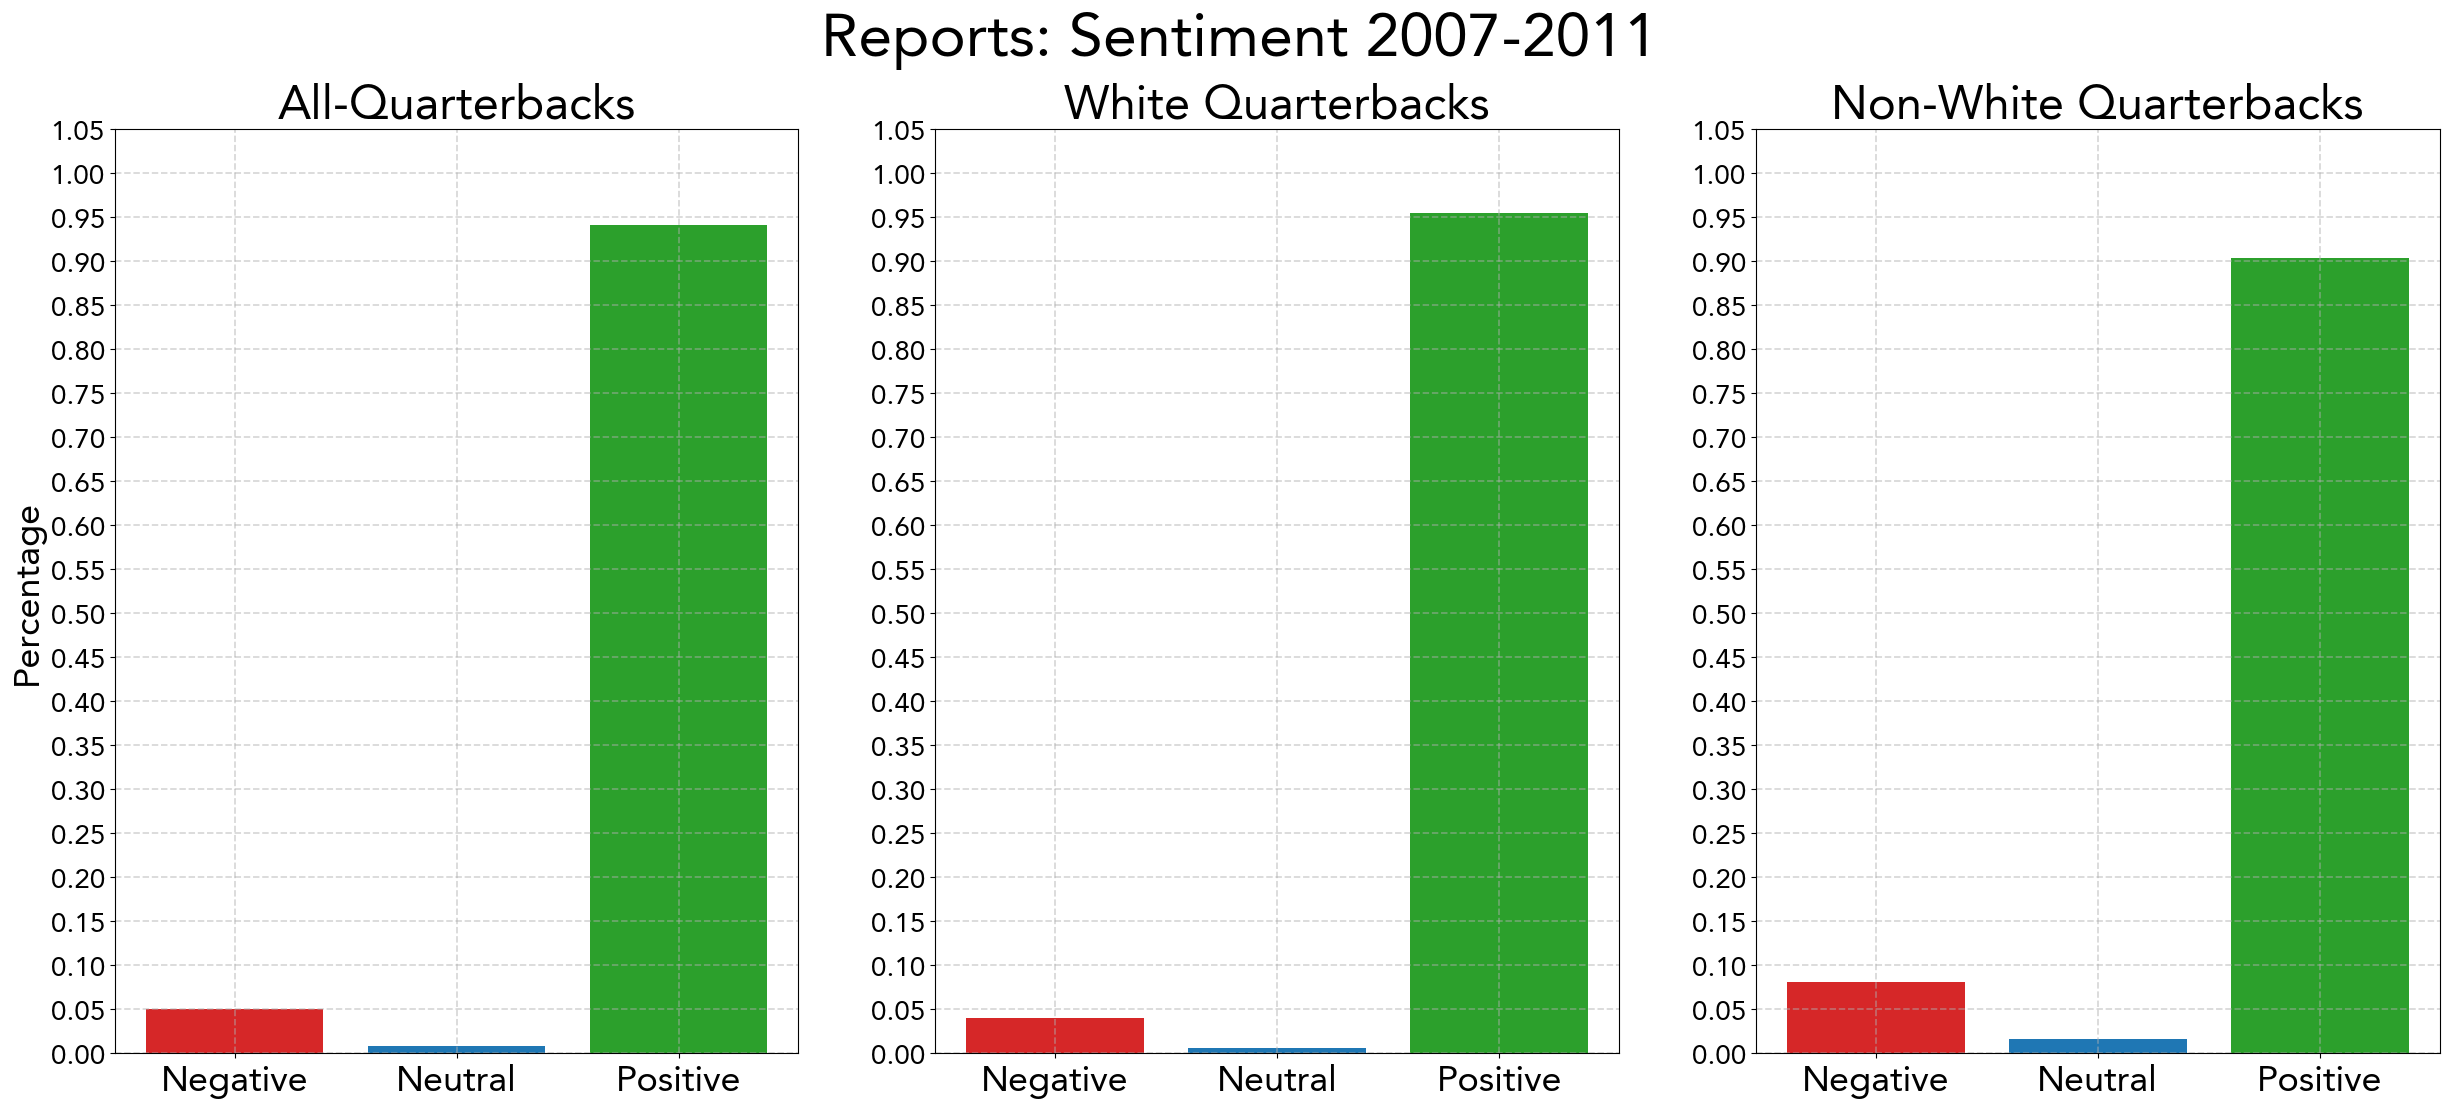

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams.update({'font.size': 20})

period = '2007-2011'
x = ['Negative', 'Neutral', 'Positive']
colors = ['tab:red', 'tab:blue', 'tab:green']

yticks = np.arange(0, 1.06, 0.05)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df5[df5['Period'] == period][x].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('Percentage', fontsize=26)

ax = axs[1]
y = df6[(df6['Race'] == 'White') & (df6['Period'] == period)][x].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('', fontsize=26)

ax = axs[2]
y = df6[(df6['Race'] == 'Non-White') & (df6['Period'] == period)][x].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('', fontsize=26)

plt.suptitle(f'Reports: Sentiment {period}', fontsize=44)
plt.show()

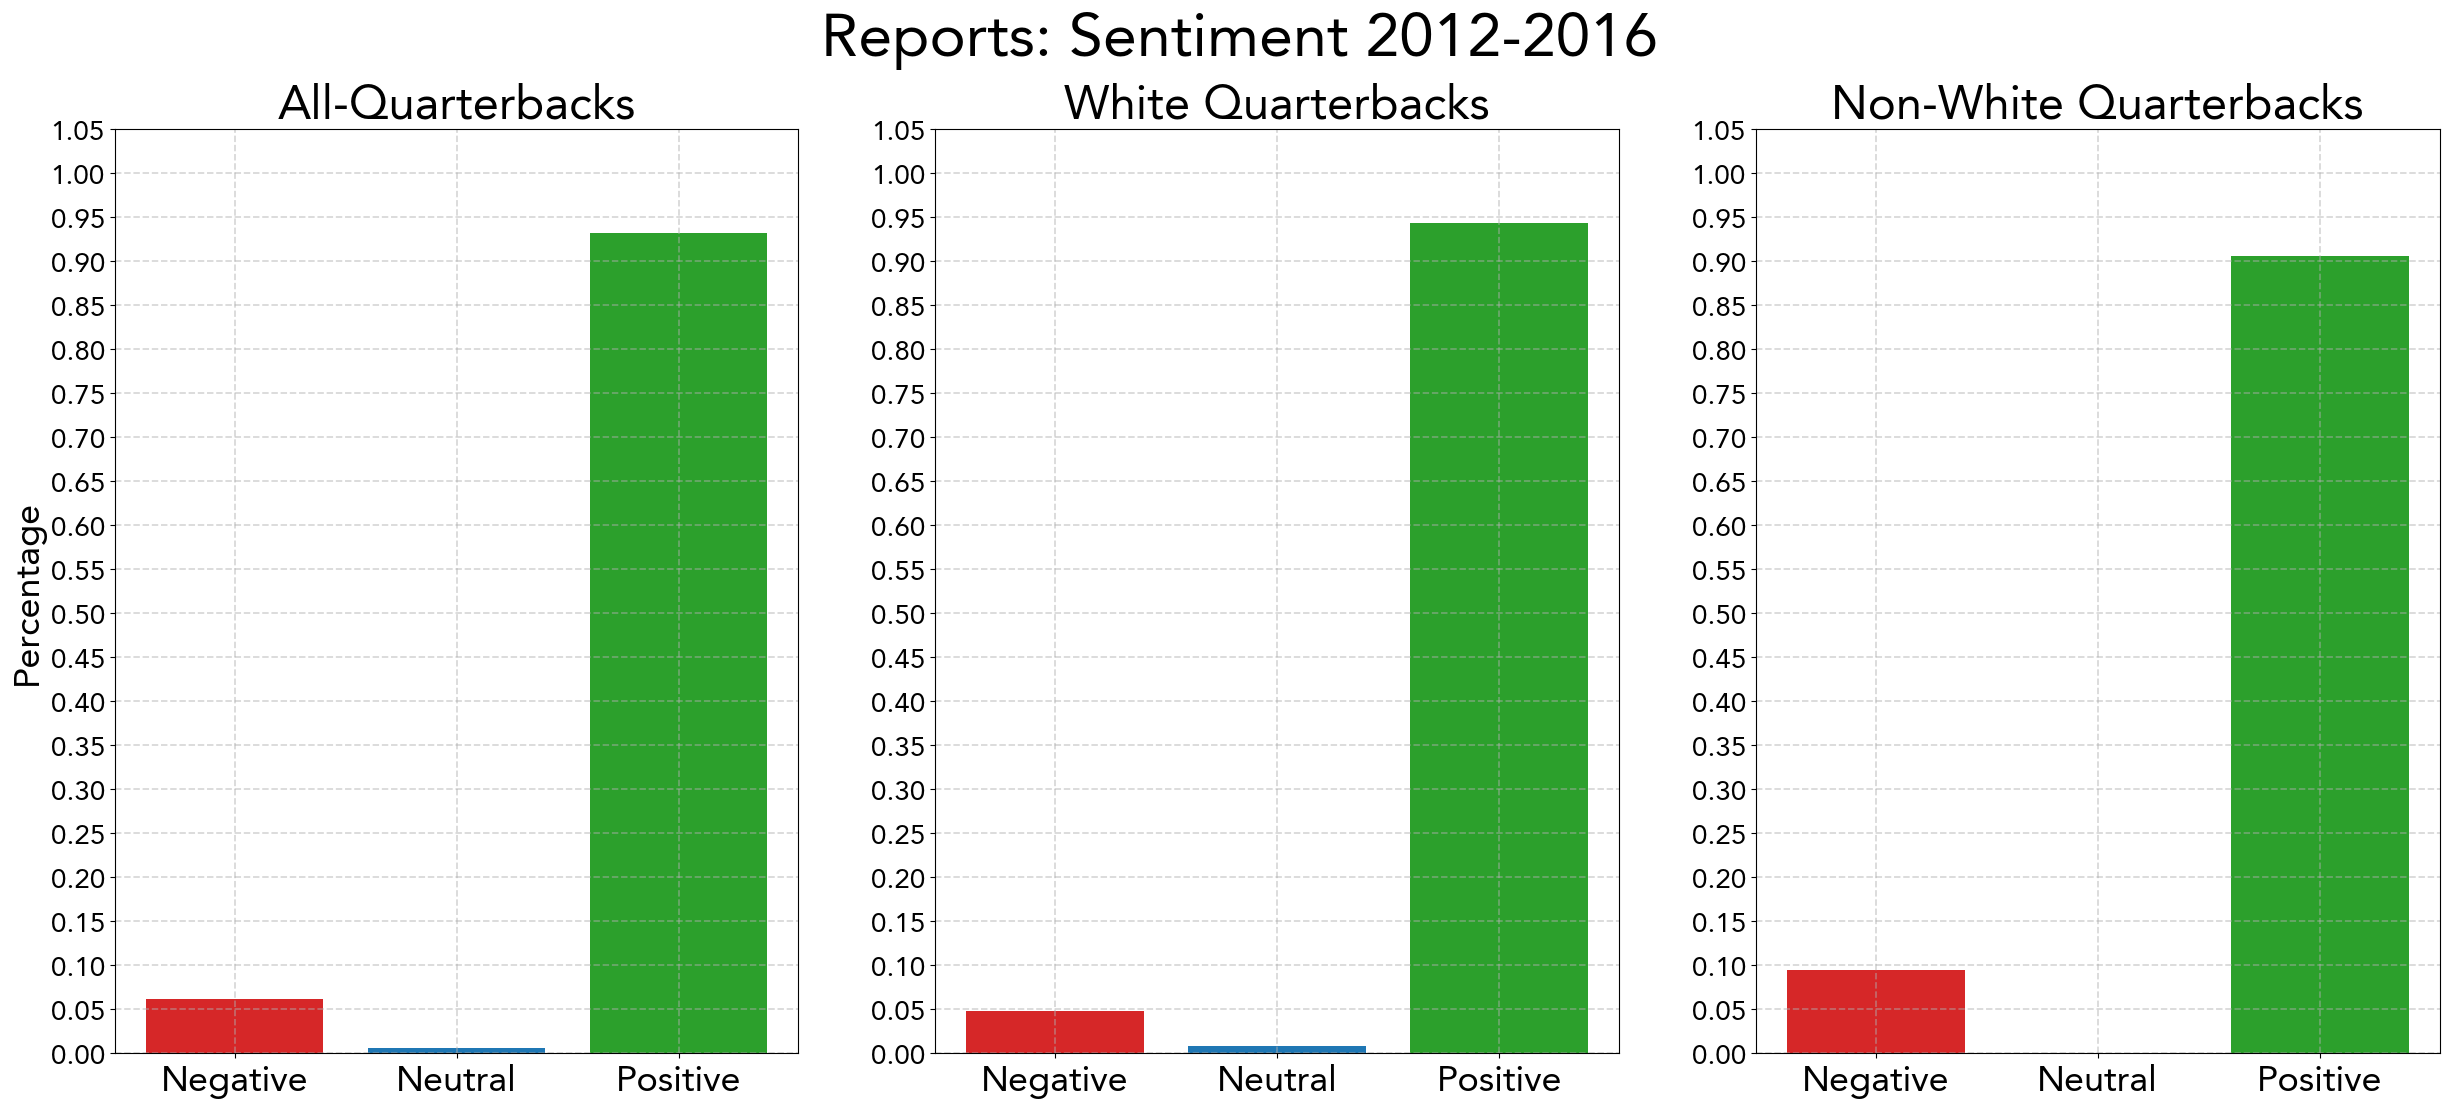

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams.update({'font.size': 20})

period = '2012-2016'
x = ['Negative', 'Neutral', 'Positive']
colors = ['tab:red', 'tab:blue', 'tab:green']

yticks = np.arange(0, 1.06, 0.05)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df5[df5['Period'] == period][x].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('Percentage', fontsize=26)

ax = axs[1]
y = df6[(df6['Race'] == 'White') & (df6['Period'] == period)][x].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('', fontsize=26)

ax = axs[2]
y = df6[(df6['Race'] == 'Non-White') & (df6['Period'] == period)][x].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('', fontsize=26)

plt.suptitle(f'Reports: Sentiment {period}', fontsize=44)
plt.show()

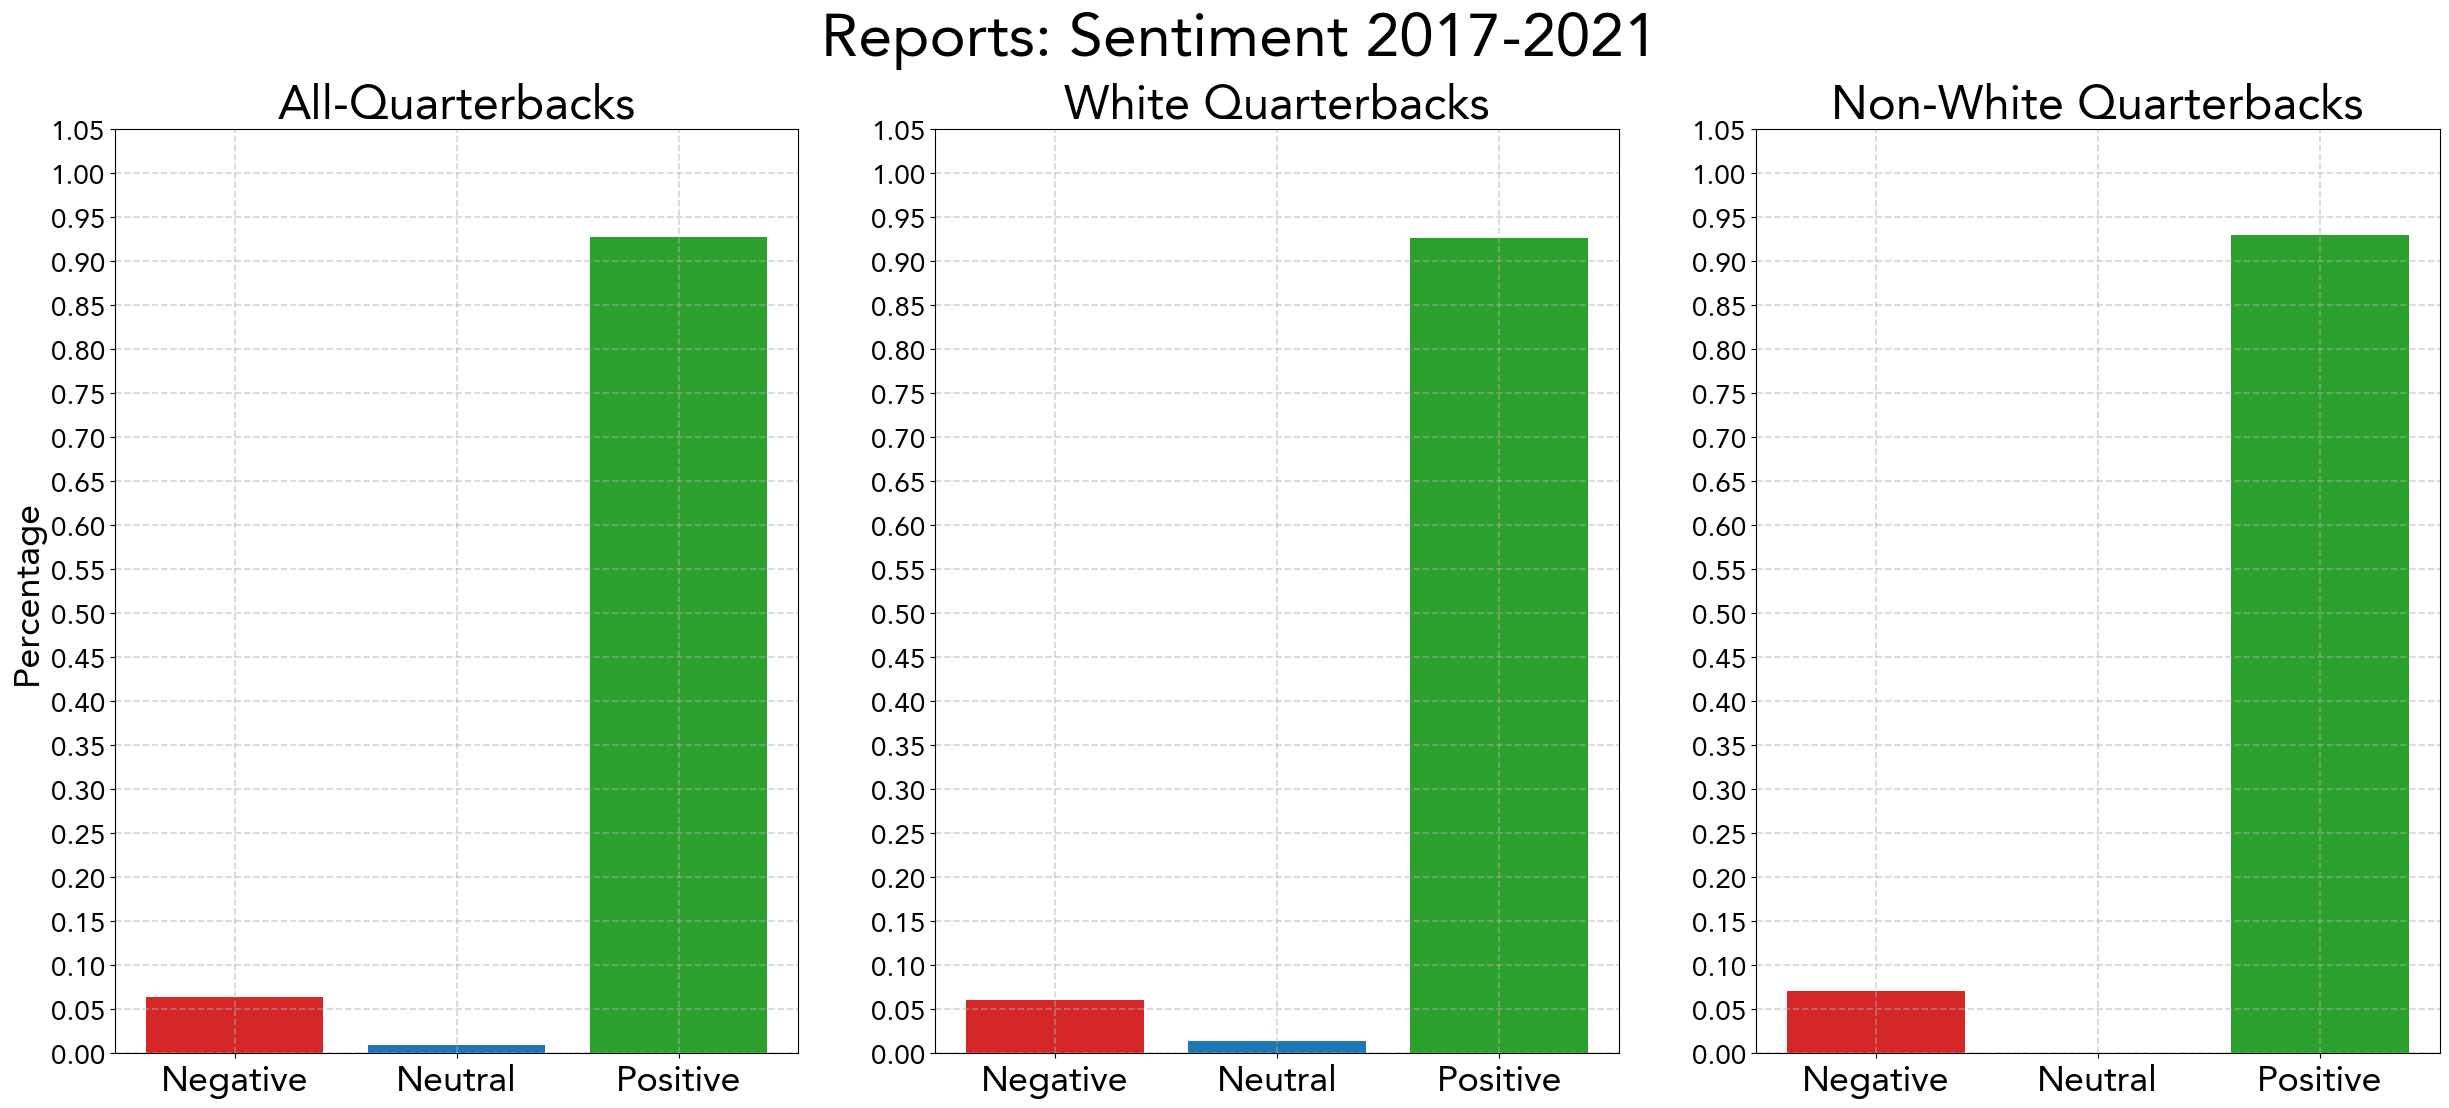

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams.update({'font.size': 20})

period = '2017-2021'
x = ['Negative', 'Neutral', 'Positive']
colors = ['tab:red', 'tab:blue', 'tab:green']

yticks = np.arange(0, 1.06, 0.05)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df5[df5['Period'] == period][x].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('Percentage', fontsize=26)

ax = axs[1]
y = df6[(df6['Race'] == 'White') & (df6['Period'] == period)][x].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('', fontsize=26)

ax = axs[2]
y = df6[(df6['Race'] == 'Non-White') & (df6['Period'] == period)][x].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks', fontsize=34)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=26)
ax.set_ylabel('', fontsize=26)

plt.suptitle(f'Reports: Sentiment {period}', fontsize=44)
plt.show()

In [23]:
data3 = data[['Race', 'Year', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']]
data3.insert(2, 'Period', '')

for index, row in data3.iterrows():
    if row['Year'] <= 2011:
        data3.at[index, 'Period'] = '2007-2011'
    elif row['Year'] >= 2017:
        data3.at[index, 'Period'] = '2017-2021'
    else:
        data3.at[index, 'Period'] = '2012-2016'

In [24]:
data4 = data3.groupby(['Period']).mean(numeric_only=True).reset_index().drop('Year', axis=1)
data4

,Period,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,2007-2011,0.107479,0.283462,0.186588,0.032183,0.390288
1,2012-2016,0.171886,0.223073,0.096706,0.068314,0.440021
2,2017-2021,0.172065,0.245515,0.146173,0.062660,0.373587


In [25]:
data5 = data3.groupby(['Race', 'Period']).mean().reset_index().sort_values(['Period', 'Race']).reset_index(drop=True).drop('Year', axis=1)
data5

,Race,Period,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,Non-White,2007-2011,0.095482,0.309039,0.179917,0.042593,0.372970
1,White,2007-2011,0.111682,0.274503,0.188925,0.028537,0.396354
2,Non-White,2012-2016,0.183021,0.217069,0.096254,0.060924,0.442731
3,White,2012-2016,0.167127,0.225638,0.096899,0.071473,0.438862
4,Non-White,2017-2021,0.164531,0.241692,0.150069,0.069361,0.374347
5,White,2017-2021,0.175655,0.247337,0.144316,0.059467,0.373225


In [26]:
df7 = df0.groupby(['Period', 'Dominant_Topic']).sum(numeric_only=True).reset_index().drop('Year', axis=1).sort_values(['Period', 'Dominant_Topic']).reset_index(drop=True)
df7 = pd.concat([df7[['Period', 'Dominant_Topic']], df7[['Negative', 'Neutral', 'Positive']].div(df7.sum(axis=1, numeric_only=True), axis=0)], axis=1)
df7 = pd.concat([df7, pd.DataFrame({'Period':['2007-2011', '2007-2011'], 'Dominant_Topic':['Topic_1', 'Topic_4'], 'Negative':[0, 0], 'Neutral':[0, 0], 'Positive':[0, 0]})]).sort_values(['Period', 'Dominant_Topic']).reset_index(drop=True)
df7

,Period,Dominant_Topic,Negative,Neutral,Positive
0,2007-2011,Topic_1,0.000000,0.000000,0.000000
1,2007-2011,Topic_2,0.028571,0.014286,0.957143
2,2007-2011,Topic_3,0.083333,0.000000,0.916667
3,2007-2011,Topic_4,0.000000,0.000000,0.000000
4,2007-2011,Topic_5,0.049587,0.008264,0.942149
5,2012-2016,Topic_1,0.100000,0.000000,0.900000
6,2012-2016,Topic_2,0.047619,0.023810,0.928571
7,2012-2016,Topic_3,0.090909,0.000000,0.909091
8,2012-2016,Topic_4,0.090909,0.000000,0.909091
9,2012-2016,Topic_5,0.058252,0.000000,0.941748


In [27]:
df8 = df0.groupby(['Race', 'Period', 'Dominant_Topic']).sum(numeric_only=True).reset_index().drop('Year', axis=1).sort_values(['Period', 'Dominant_Topic']).reset_index(drop=True)
df8 = pd.concat([df8[['Race', 'Period', 'Dominant_Topic']], df8[['Negative', 'Neutral', 'Positive']].div(df8.sum(axis=1, numeric_only=True), axis=0)], axis=1)
df8 = pd.concat([df8, pd.DataFrame({'Race':['White', 'White'], 'Period':['2007-2011', '2007-2011'], 'Dominant_Topic':['Topic_1', 'Topic_4'], 'Negative':[0, 0], 'Neutral':[0, 0], 'Positive':[0, 0]})]).sort_values(['Period', 'Dominant_Topic']).reset_index(drop=True)
df8 = pd.concat([df8, pd.DataFrame({'Race':['Non-White', 'Non-White'], 'Period':['2007-2011', '2007-2011'], 'Dominant_Topic':['Topic_1', 'Topic_4'], 'Negative':[0, 0], 'Neutral':[0, 0], 'Positive':[0, 0]})]).sort_values(['Period', 'Dominant_Topic']).reset_index(drop=True)
df8

,Race,Period,Dominant_Topic,Negative,Neutral,Positive
0,White,2007-2011,Topic_1,0.000000,0.000000,0.000000
1,Non-White,2007-2011,Topic_1,0.000000,0.000000,0.000000
2,Non-White,2007-2011,Topic_2,0.045455,0.045455,0.909091
3,White,2007-2011,Topic_2,0.020833,0.000000,0.979167
4,Non-White,2007-2011,Topic_3,0.272727,0.000000,0.727273
5,White,2007-2011,Topic_3,0.027027,0.000000,0.972973
6,White,2007-2011,Topic_4,0.000000,0.000000,0.000000
7,Non-White,2007-2011,Topic_4,0.000000,0.000000,0.000000
8,Non-White,2007-2011,Topic_5,0.034483,0.000000,0.965517
9,White,2007-2011,Topic_5,0.054348,0.010870,0.934783


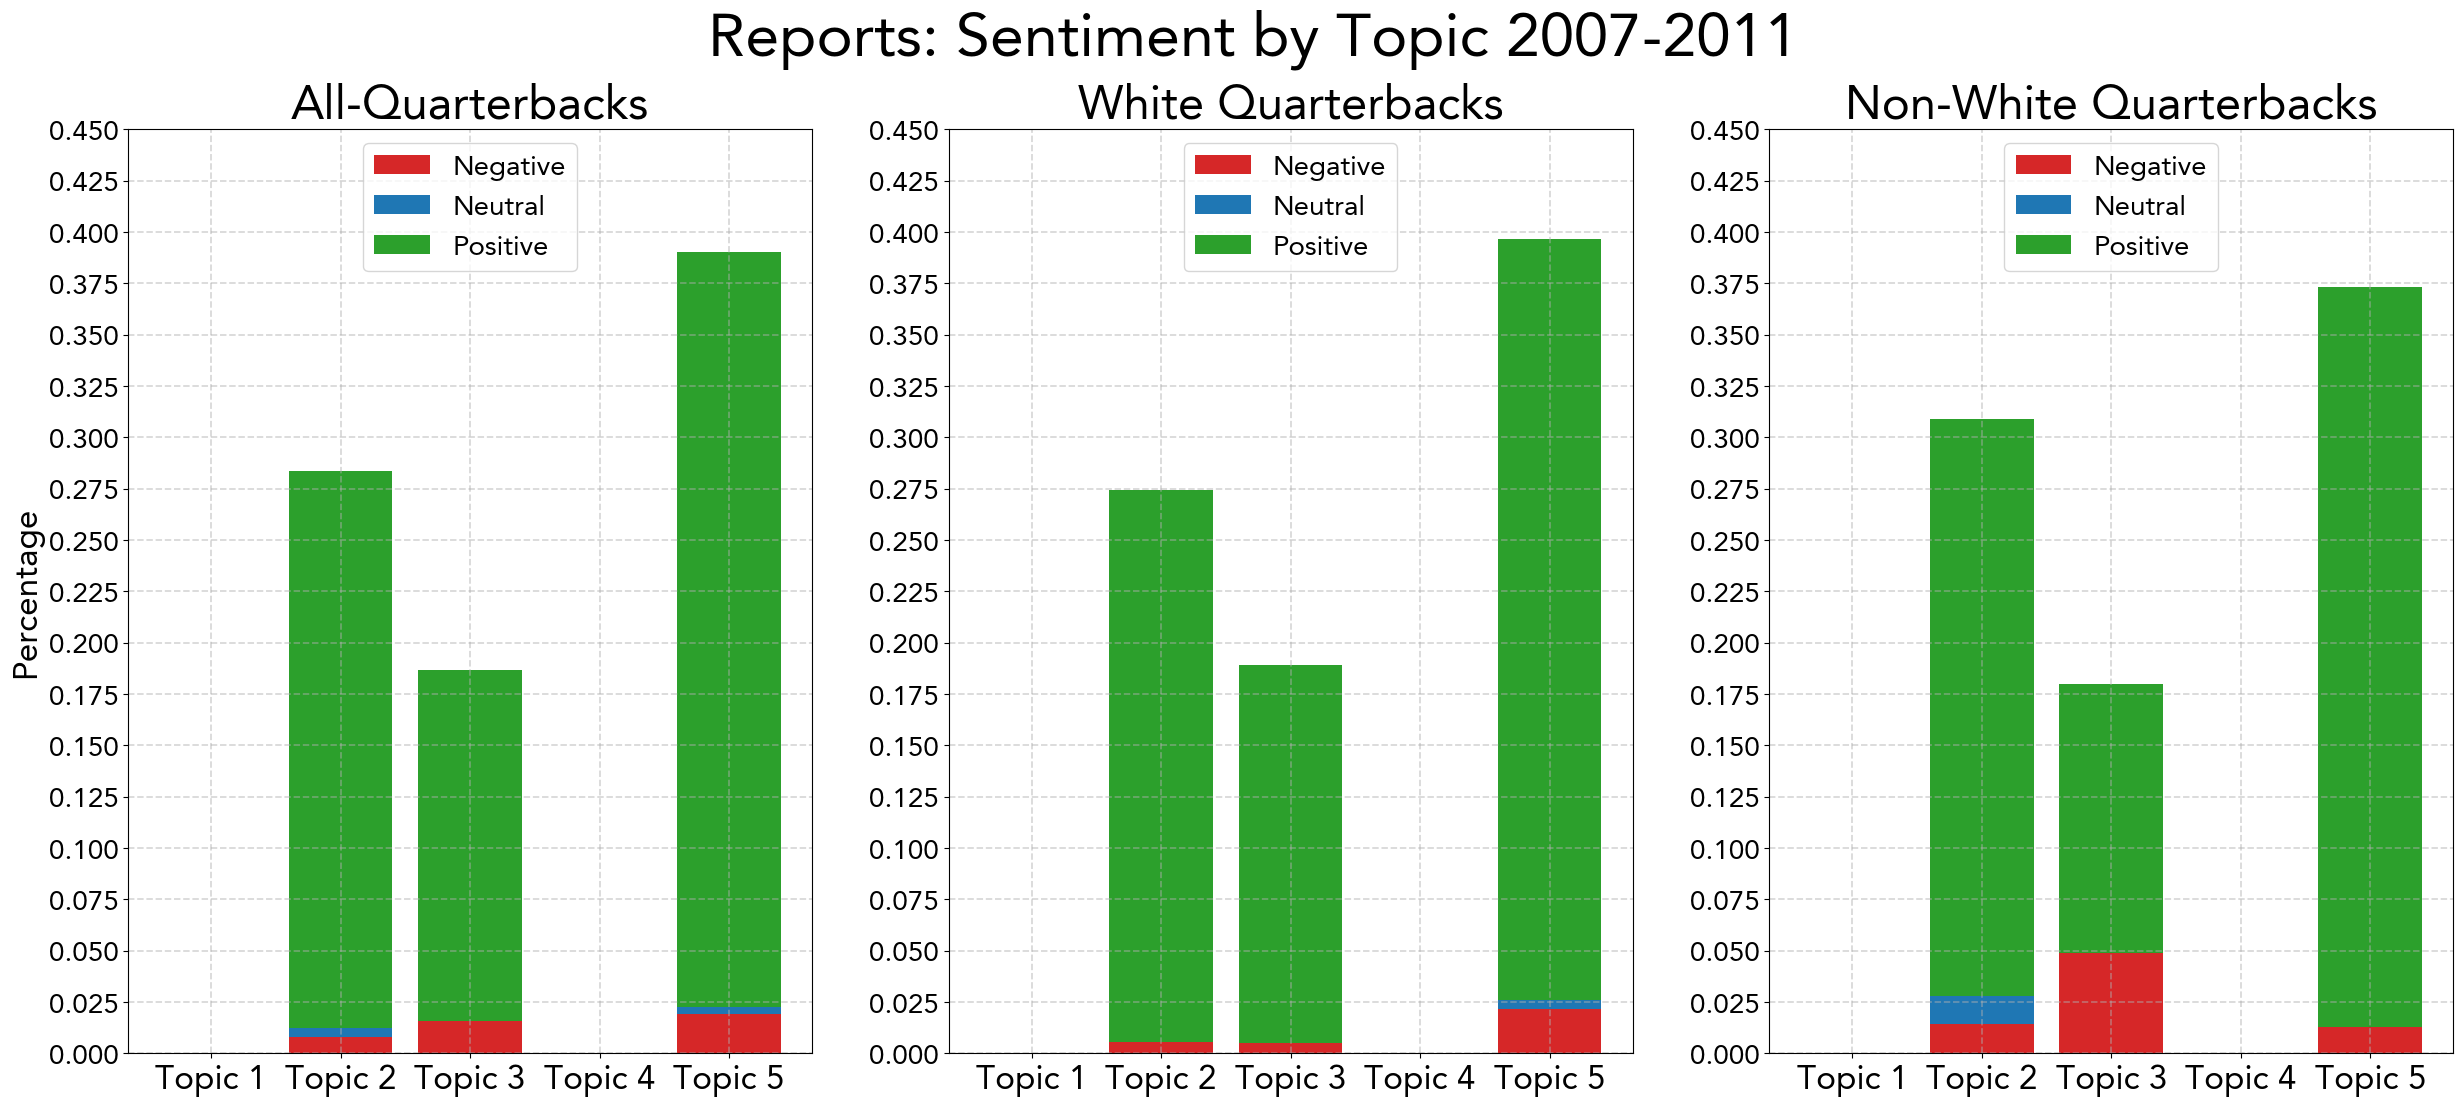

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'Avenir'

period = '2007-2011'
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']

yticks = np.arange(0, 0.46, 0.025)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y1 = df7[df7['Period'] == period]['Negative'] * np.array(data4[data4['Period'] == period].reset_index(drop=True).loc[0][1:])
y2 = df7[df7['Period'] == period]['Neutral'] * np.array(data4[data4['Period'] == period].reset_index(drop=True).loc[0][1:])
y3 = df7[df7['Period'] == period]['Positive'] * np.array(data4[data4['Period'] == period].reset_index(drop=True).loc[0][1:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks', fontsize=34)
ax.legend(loc='upper center')
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('Percentage', fontsize=24)

ax = axs[1]
y1 = df8[(df8['Period'] == period) & (df8['Race'] == 'White')]['Negative'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'White')].reset_index(drop=True).loc[0][2:])
y2 = df8[(df8['Period'] == period) & (df8['Race'] == 'White')]['Neutral'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'White')].reset_index(drop=True).loc[0][2:])
y3 = df8[(df8['Period'] == period) & (df8['Race'] == 'White')]['Positive'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'White')].reset_index(drop=True).loc[0][2:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks', fontsize=34)
ax.legend(loc='upper center')
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('', fontsize=24)

ax = axs[2]
y1 = df8[(df8['Period'] == period) & (df8['Race'] == 'Non-White')]['Negative'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'Non-White')].reset_index(drop=True).loc[0][2:])
y2 = df8[(df8['Period'] == period) & (df8['Race'] == 'Non-White')]['Neutral'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'Non-White')].reset_index(drop=True).loc[0][2:])
y3 = df8[(df8['Period'] == period) & (df8['Race'] == 'Non-White')]['Positive'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'Non-White')].reset_index(drop=True).loc[0][2:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks', fontsize=34)
ax.legend(loc='upper center')
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('', fontsize=24)

plt.suptitle(f'Reports: Sentiment by Topic {period}', fontsize=44)
plt.show()

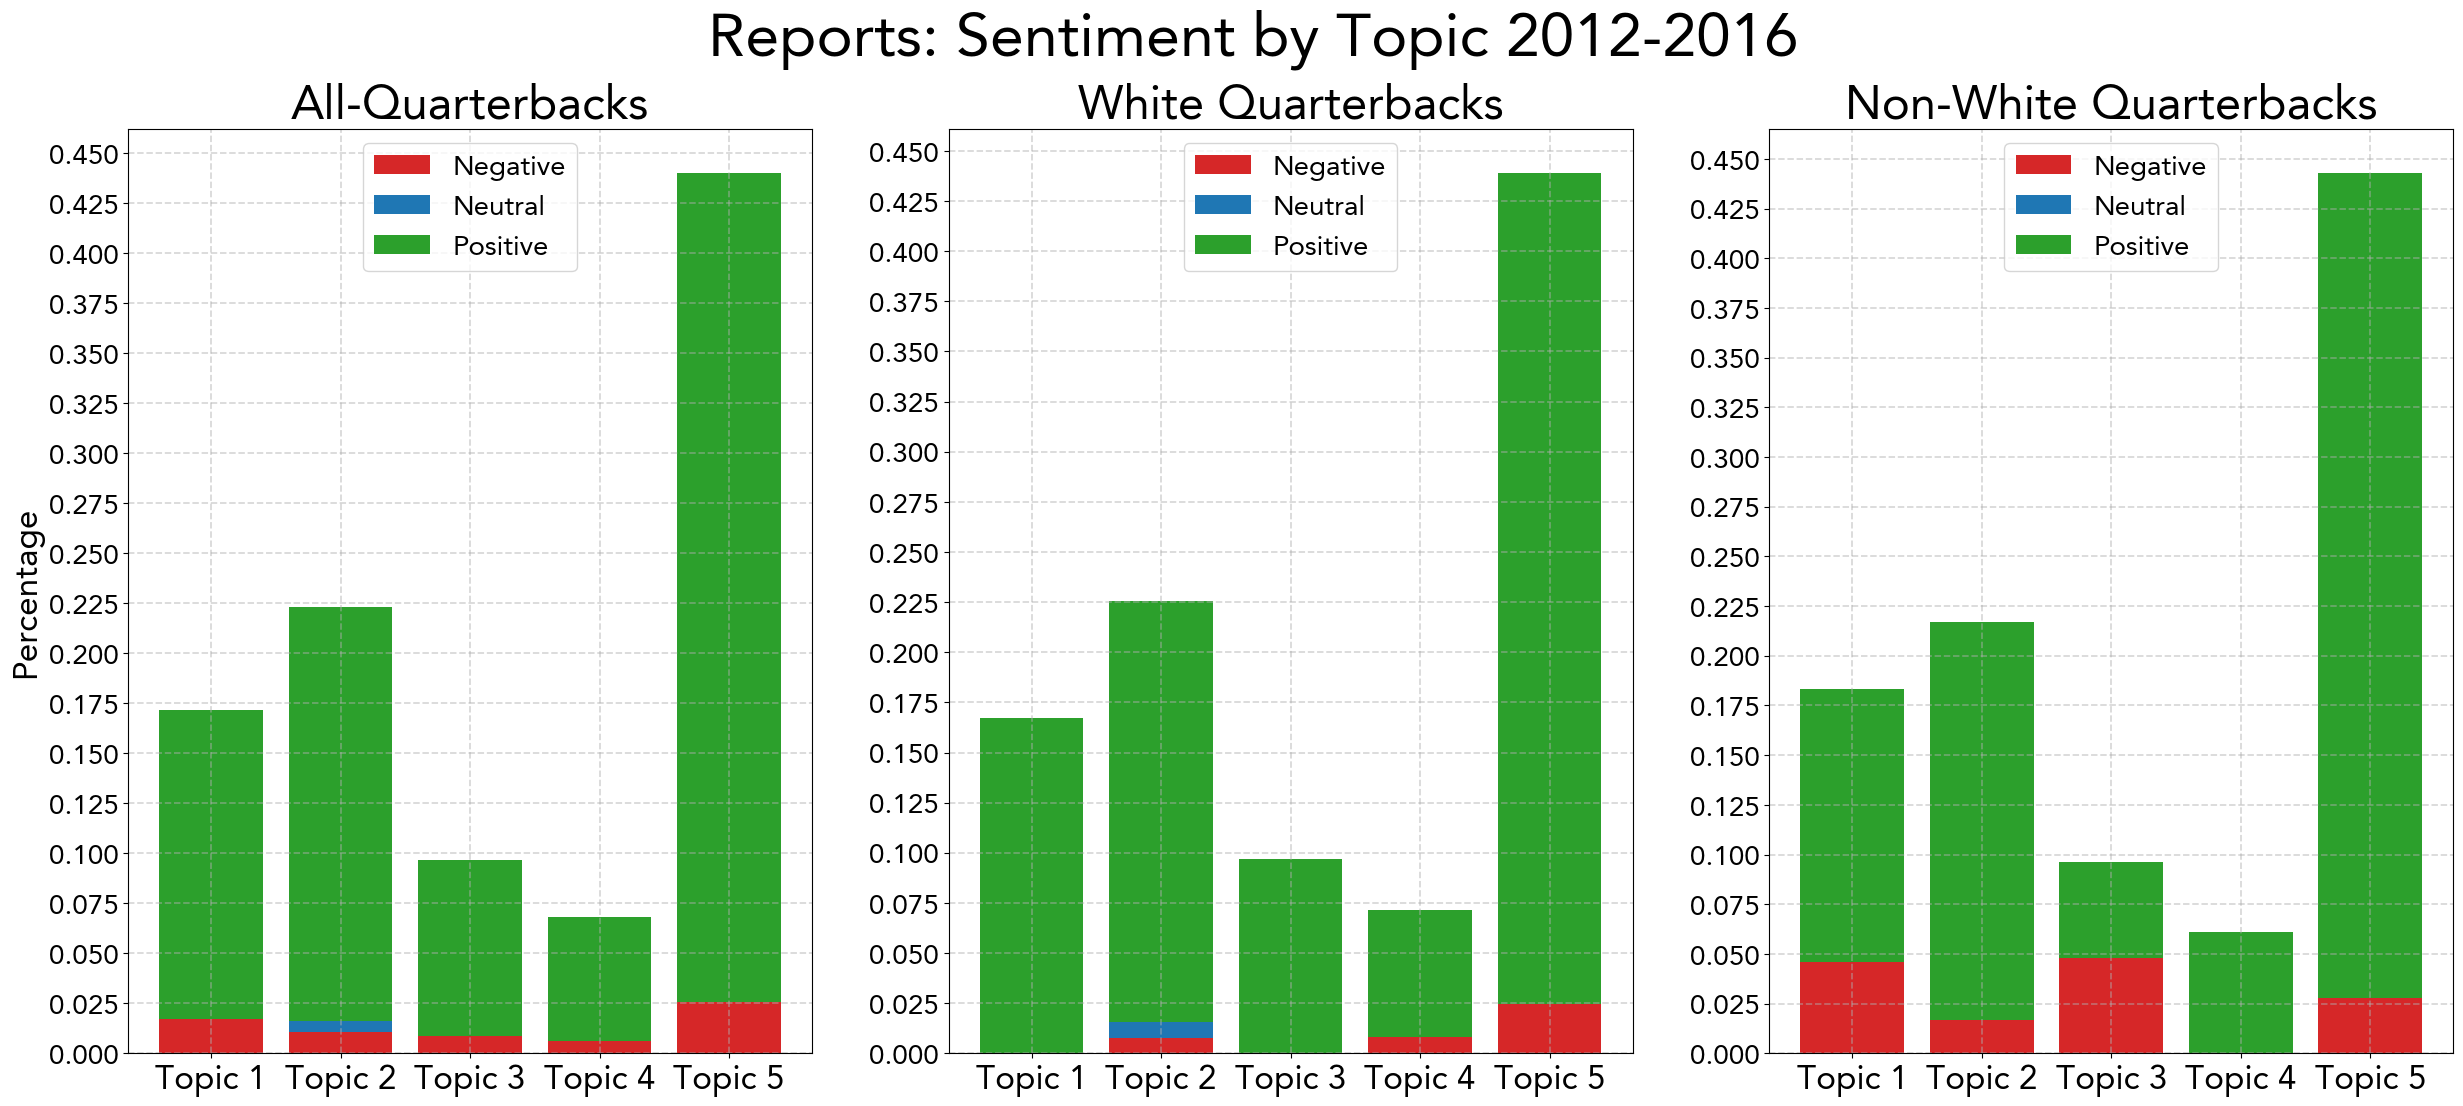

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'Avenir'

period = '2012-2016'
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']

yticks = np.arange(0, 0.46, 0.025)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y1 = df7[df7['Period'] == period]['Negative'] * np.array(data4[data4['Period'] == period].reset_index(drop=True).loc[0][1:])
y2 = df7[df7['Period'] == period]['Neutral'] * np.array(data4[data4['Period'] == period].reset_index(drop=True).loc[0][1:])
y3 = df7[df7['Period'] == period]['Positive'] * np.array(data4[data4['Period'] == period].reset_index(drop=True).loc[0][1:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks', fontsize=34)
ax.legend(loc='upper center')
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('Percentage', fontsize=24)

ax = axs[1]
y1 = df8[(df8['Period'] == period) & (df8['Race'] == 'White')]['Negative'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'White')].reset_index(drop=True).loc[0][2:])
y2 = df8[(df8['Period'] == period) & (df8['Race'] == 'White')]['Neutral'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'White')].reset_index(drop=True).loc[0][2:])
y3 = df8[(df8['Period'] == period) & (df8['Race'] == 'White')]['Positive'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'White')].reset_index(drop=True).loc[0][2:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks', fontsize=34)
ax.legend(loc='upper center')
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('', fontsize=24)

ax = axs[2]
y1 = df8[(df8['Period'] == period) & (df8['Race'] == 'Non-White')]['Negative'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'Non-White')].reset_index(drop=True).loc[0][2:])
y2 = df8[(df8['Period'] == period) & (df8['Race'] == 'Non-White')]['Neutral'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'Non-White')].reset_index(drop=True).loc[0][2:])
y3 = df8[(df8['Period'] == period) & (df8['Race'] == 'Non-White')]['Positive'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'Non-White')].reset_index(drop=True).loc[0][2:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks', fontsize=34)
ax.legend(loc='upper center')
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('', fontsize=24)

plt.suptitle(f'Reports: Sentiment by Topic {period}', fontsize=44)
plt.show()

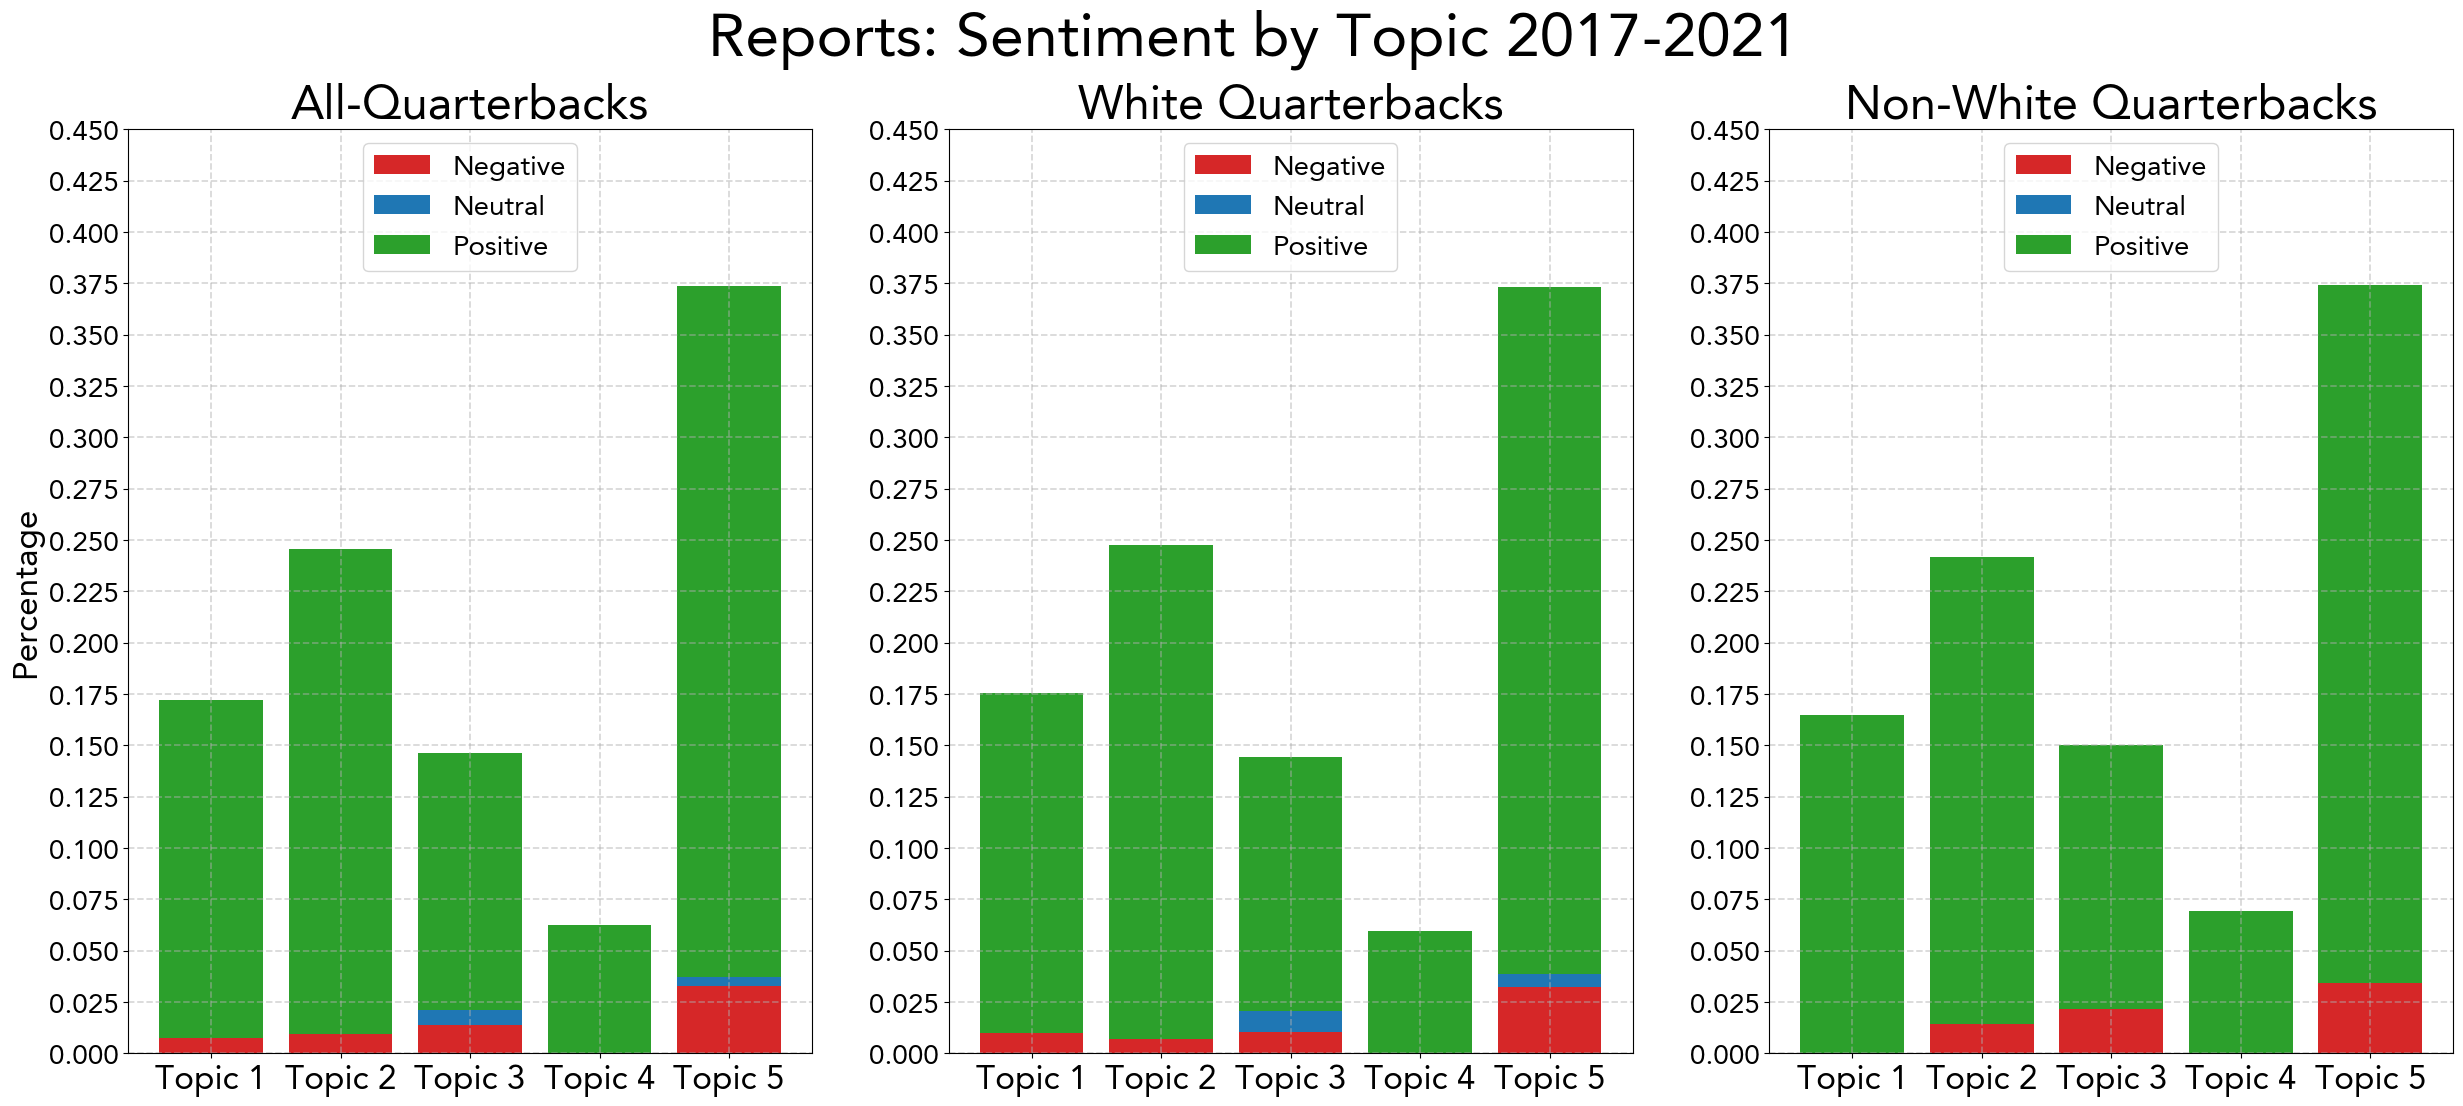

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'Avenir'

period = '2017-2021'
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']

yticks = np.arange(0, 0.46, 0.025)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y1 = df7[df7['Period'] == period]['Negative'] * np.array(data4[data4['Period'] == period].reset_index(drop=True).loc[0][1:])
y2 = df7[df7['Period'] == period]['Neutral'] * np.array(data4[data4['Period'] == period].reset_index(drop=True).loc[0][1:])
y3 = df7[df7['Period'] == period]['Positive'] * np.array(data4[data4['Period'] == period].reset_index(drop=True).loc[0][1:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks', fontsize=34)
ax.legend(loc='upper center')
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('Percentage', fontsize=24)

ax = axs[1]
y1 = df8[(df8['Period'] == period) & (df8['Race'] == 'White')]['Negative'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'White')].reset_index(drop=True).loc[0][2:])
y2 = df8[(df8['Period'] == period) & (df8['Race'] == 'White')]['Neutral'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'White')].reset_index(drop=True).loc[0][2:])
y3 = df8[(df8['Period'] == period) & (df8['Race'] == 'White')]['Positive'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'White')].reset_index(drop=True).loc[0][2:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks', fontsize=34)
ax.legend(loc='upper center')
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('', fontsize=24)

ax = axs[2]
y1 = df8[(df8['Period'] == period) & (df8['Race'] == 'Non-White')]['Negative'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'Non-White')].reset_index(drop=True).loc[0][2:])
y2 = df8[(df8['Period'] == period) & (df8['Race'] == 'Non-White')]['Neutral'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'Non-White')].reset_index(drop=True).loc[0][2:])
y3 = df8[(df8['Period'] == period) & (df8['Race'] == 'Non-White')]['Positive'] * np.array(data5[(data5['Period'] == period) & (data5['Race'] == 'Non-White')].reset_index(drop=True).loc[0][2:])
ax.bar(x, y1, color='tab:red', label='Negative')
ax.bar(x, y2, color='tab:blue', bottom=y1, label='Neutral')
ax.bar(x, y3, color='tab:green', bottom=list(map(lambda x, y: x + y, y1, y2)), label='Positive')
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks', fontsize=34)
ax.legend(loc='upper center')
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=24)
ax.set_ylabel('', fontsize=24)

plt.suptitle(f'Reports: Sentiment by Topic {period}', fontsize=44)
plt.show()